In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import matplotlib.ticker as mtick

# Conectar ao banco de dados
conn = sqlite3.connect(r'C:\Users\louis\datatech\Database\walmart_fraudes.db')

C:\Users\louis\AppData\Local\Temp\ipykernel_19140\2243686280.py:115: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='region_hour', y='missing_rate', data=systemic_df, palette='coolwarm')


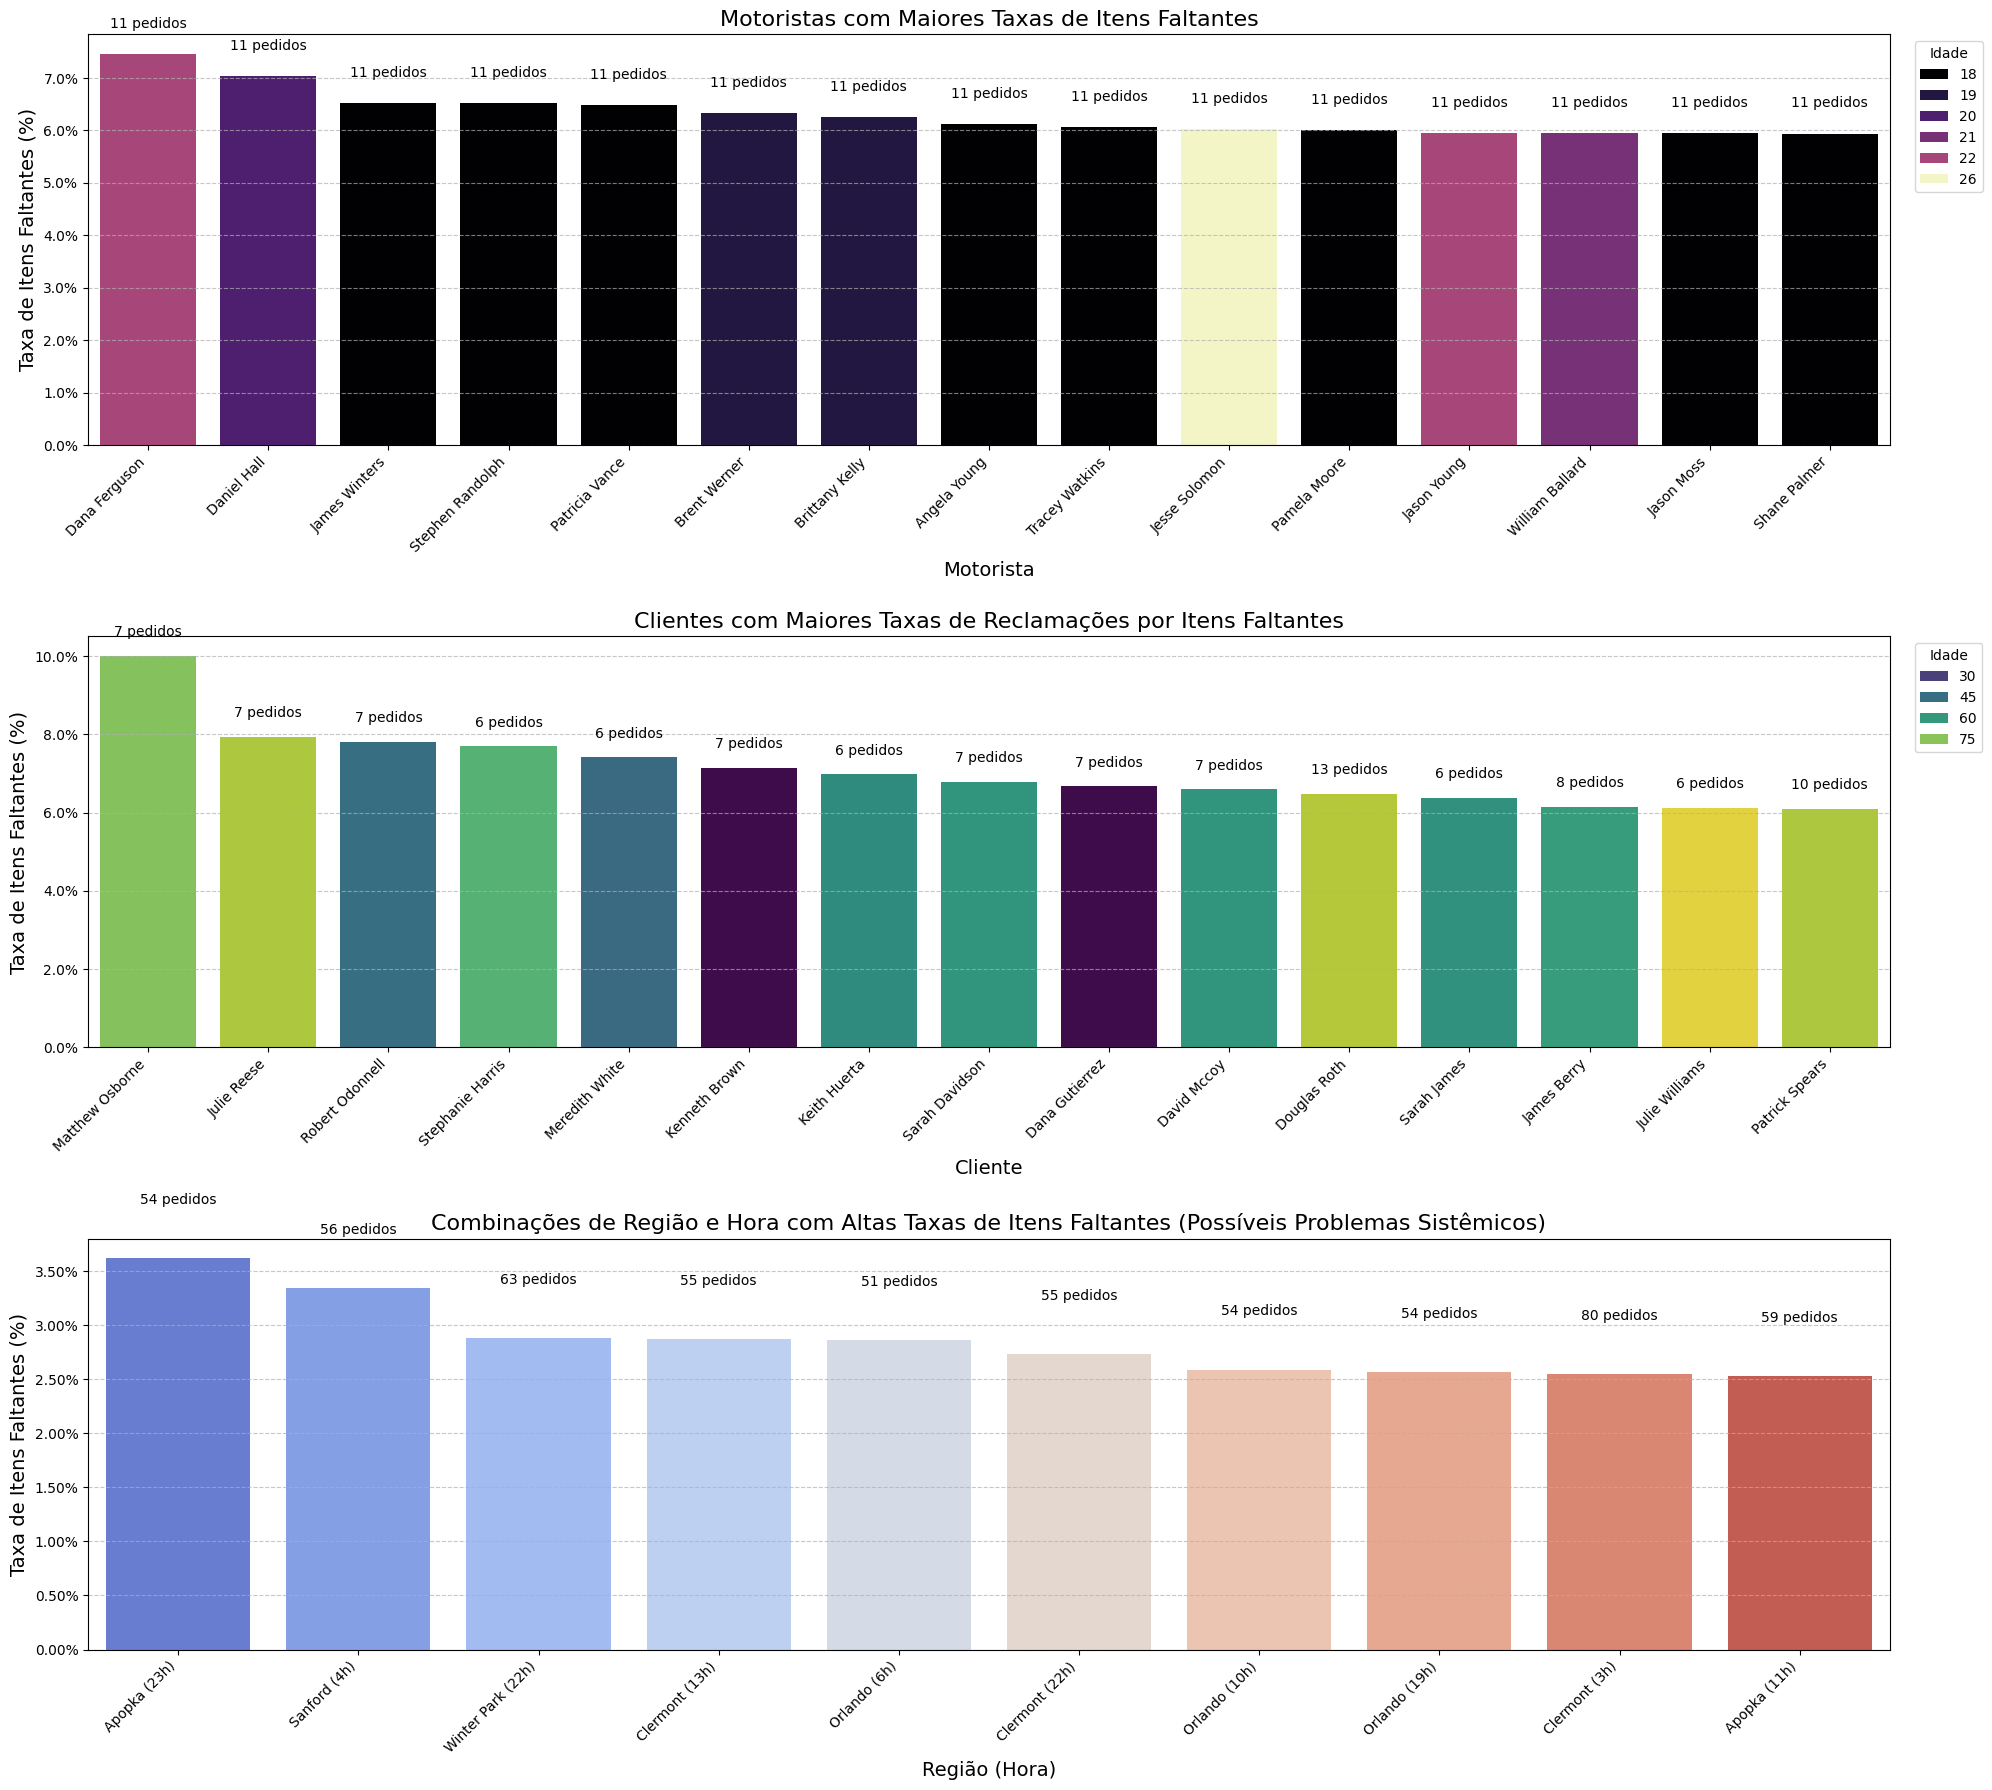

Resumo da Análise de Responsabilidades:

1. Evidências de Fraude de Motoristas:
driver_id      driver_name  age  total_orders  total_missing_items  missing_rate
WDID10322    Dana Ferguson   22            11                    5          7.46
WDID10222      Daniel Hall   20            11                    5          7.04
WDID09884    James Winters   18            11                    6          6.52
WDID09875 Stephen Randolph   18            11                    6          6.52
WDID10447   Patricia Vance   18            11                    5          6.49

2. Evidências de Fraude de Clientes:
customer_id    customer_name  customer_age  total_orders  total_missing_items  missing_rate
   WCID5762  Matthew Osborne            74             7                    4         10.00
   WCID5905      Julie Reese            80             7                    5          7.94
   WCID5594  Robert Odonnell            45             7                    5          7.81
   WCID5630 Stephanie Harris

In [2]:
# Análise combinada para atribuição de responsabilidades

# 1. Identificação de motoristas com altas taxas de itens faltantes
query_drivers = """
SELECT 
    d.driver_id,
    d.driver_name,
    d.age,
    d.Trips,
    COUNT(o.order_id) AS total_orders,
    SUM(o.items_missing) AS total_missing_items,
    ROUND(SUM(o.items_missing) * 100.0 / (SUM(o.items_delivered) + SUM(o.items_missing)), 2) AS missing_rate,
    ROUND(COUNT(CASE WHEN o.items_missing > 0 THEN 1 END) * 100.0 / COUNT(o.order_id), 2) AS problem_order_percentage
FROM 
    drivers d
JOIN 
    orders o ON d.driver_id = o.driver_id
GROUP BY 
    d.driver_id
HAVING 
    total_orders > 5  -- Filtrar motoristas com poucos pedidos
ORDER BY 
    missing_rate DESC
LIMIT 
    15
"""

drivers_suspicious_df = pd.read_sql_query(query_drivers, conn)

# 2. Identificação de clientes com altas taxas de reclamações
query_customers = """
SELECT 
    c.customer_id,
    c.customer_name,
    c.customer_age,
    COUNT(o.order_id) AS total_orders,
    SUM(o.items_missing) AS total_missing_items,
    ROUND(SUM(o.items_missing) * 100.0 / (SUM(o.items_delivered) + SUM(o.items_missing)), 2) AS missing_rate,
    ROUND(COUNT(CASE WHEN o.items_missing > 0 THEN 1 END) * 100.0 / COUNT(o.order_id), 2) AS problem_order_percentage
FROM 
    customers c
JOIN 
    orders o ON c.customer_id = o.customer_id
GROUP BY 
    c.customer_id
HAVING 
    total_orders > 5  -- Filtrar clientes com poucos pedidos
ORDER BY 
    missing_rate DESC
LIMIT 
    15
"""

customers_suspicious_df = pd.read_sql_query(query_customers, conn)

# 3. Identificar possíveis problemas sistêmicos (combinações de região e hora)
query_systemic = """
SELECT 
    region,
    delivery_hour_only AS hour,
    COUNT(order_id) AS total_orders,
    SUM(items_missing) AS total_missing_items,
    ROUND(SUM(items_missing) * 100.0 / (SUM(items_delivered) + SUM(items_missing)), 2) AS missing_rate,
    ROUND(COUNT(CASE WHEN items_missing > 0 THEN 1 END) * 100.0 / COUNT(order_id), 2) AS problem_order_percentage
FROM 
    orders
GROUP BY 
    region, delivery_hour_only
HAVING 
    total_orders > 10  -- Filtrar combinações com poucos pedidos
ORDER BY 
    missing_rate DESC
LIMIT 
    10
"""

systemic_df = pd.read_sql_query(query_systemic, conn)

# Visualização
plt.figure(figsize=(20, 18))

# Gráfico 1: Motoristas com as maiores taxas de itens faltantes
plt.subplot(3, 1, 1)
ax1 = sns.barplot(x='driver_name', y='missing_rate', hue='age', data=drivers_suspicious_df, palette='magma')
plt.title('Motoristas com Maiores Taxas de Itens Faltantes', fontsize=16)
plt.xlabel('Motorista', fontsize=14)
plt.ylabel('Taxa de Itens Faltantes (%)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Idade', bbox_to_anchor=(1.01, 1), loc='upper left')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())

# Adicionar os valores acima das barras
for i, row in enumerate(drivers_suspicious_df.iterrows()):
    plt.text(i, row[1]['missing_rate']+0.5, f"{row[1]['total_orders']} pedidos", ha='center')

# Gráfico 2: Clientes com as maiores taxas de reclamações
plt.subplot(3, 1, 2)
ax2 = sns.barplot(x='customer_name', y='missing_rate', hue='customer_age', data=customers_suspicious_df, palette='viridis')
plt.title('Clientes com Maiores Taxas de Reclamações por Itens Faltantes', fontsize=16)
plt.xlabel('Cliente', fontsize=14)
plt.ylabel('Taxa de Itens Faltantes (%)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Idade', bbox_to_anchor=(1.01, 1), loc='upper left')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())

# Adicionar os valores acima das barras
for i, row in enumerate(customers_suspicious_df.iterrows()):
    plt.text(i, row[1]['missing_rate']+0.5, f"{row[1]['total_orders']} pedidos", ha='center')

# Gráfico 3: Problemas sistêmicos (região + hora)
plt.subplot(3, 1, 3)
systemic_df['region_hour'] = systemic_df['region'] + ' (' + systemic_df['hour'].astype(str) + 'h)'
sns.barplot(x='region_hour', y='missing_rate', data=systemic_df, palette='coolwarm')
plt.title('Combinações de Região e Hora com Altas Taxas de Itens Faltantes (Possíveis Problemas Sistêmicos)', fontsize=16)
plt.xlabel('Região (Hora)', fontsize=14)
plt.ylabel('Taxa de Itens Faltantes (%)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())

# Adicionar os valores acima das barras
for i, row in enumerate(systemic_df.iterrows()):
    plt.text(i, row[1]['missing_rate']+0.5, f"{row[1]['total_orders']} pedidos", ha='center')

plt.tight_layout()
plt.show()

# Fechar a conexão
conn.close()

# Criar um resumo de atribuição de responsabilidades
print("Resumo da Análise de Responsabilidades:\n")

print("1. Evidências de Fraude de Motoristas:")
print(drivers_suspicious_df[['driver_id', 'driver_name', 'age', 'total_orders', 'total_missing_items', 'missing_rate']].head(5).to_string(index=False))
print()

print("2. Evidências de Fraude de Clientes:")
print(customers_suspicious_df[['customer_id', 'customer_name', 'customer_age', 'total_orders', 'total_missing_items', 'missing_rate']].head(5).to_string(index=False))
print()

print("3. Evidências de Problemas Sistêmicos:")
print(systemic_df[['region', 'hour', 'total_orders', 'total_missing_items', 'missing_rate']].head(5).to_string(index=False))